In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
import smogn
import pandas
from collections import Counter
from multiprocessing import Pool
from notebook import notebookapp
from numpy import matlib
from scipy import ndimage
from itertools import compress
from decimal import Decimal

In [3]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (45,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [4]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 0
reextract = 0
reload = 0
resmogn = 0
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/media/mts_dbs/dbs/complete_cases/nii/qsm/'
s_directory = '/media/mts_dbs/dbs/complete_cases/nii/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)

case_list = []
d_count = 0
if reload == 1:
    for seg_filename in s_directory:
        id = seg_filename[12:14]
        seg = nib.load('/media/mts_dbs/dbs/complete_cases/nii/seg/'+seg_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())
        qsm = nib.load('/media/mts_dbs/dbs/complete_cases/nii/qsm/qsm_'+str(id)+'.nii.gz')
        qsms.append(qsm.get_fdata())
        print('Appending arrays with segmentation',seg_filename,'and QSM','qsm_'+str(id)+'.nii.gz')
        case_list.append('qsm_'+str(id)+'.nii.gz')
        n_cases = len(segs)
        d_count = d_count+1
        qsms_wl = np.asarray(qsms)
        segs_wl = np.asarray(segs)
        with open('./pickles/segs', 'wb') as fp:  
            pickle.dump(segs, fp)

        with open('./pickles/qsms', 'wb') as fp:  
            pickle.dump(qsms, fp)

else:
    with open('/data/Ali/RadDBS-QSM/src/jupyter/pickles/segs_all', "rb") as fp:  
        segs = pickle.load(fp)

    with open('/data/Ali/RadDBS-QSM/src/jupyter/pickles/qsms_all', "rb") as fp:  
        qsms = pickle.load(fp)

In [5]:
if visualize == 1:
    qsms_wl = np.asarray(qsms)
    segs_wl = np.asarray(segs)
    qsms_wl[qsms_wl < m1] = m1
    qsms_wl[qsms_wl > m2] = m2
    n_cases = len(segs)
    multi_slice_viewer(np.hstack(((np.vstack(qsms_wl[:n_cases//2,:,:,:]/1000+0*segs_wl[:n_cases//2,:,:,:]).T),
                                  (np.vstack(qsms_wl[(n_cases-n_cases//2):,:,:,:]/1000+0*segs_wl[(n_cases-n_cases//2):,:,:,:]).T))))
   
                                    
    label_min = np.partition(np.unique(seg.get_fdata().ravel()), 1)[1]
    label_max = np.amax(seg.get_fdata())

In [6]:
file_dir = '/data/Ali/RadDBS-QSM/src/csv'
# Load patient data
os.chdir(file_dir)
df = pd.read_csv('QSMNONMOTOR__2023-11-08.csv')

In [7]:
# Make a copy
dfd = df.copy()
# Drop blank columns
for (columnName, columnData) in dfd.iteritems():
    if columnData.isnull().all():
        print('Dropping NaN column at',columnName)
        dfd.drop(columnName,axis=1,inplace=True)
# # Add relevant column names from headers
# for (columnName, columnData) in dfd.iteritems():
#         dfd.rename(columns={columnName:columnName+': '+columnData.values[0]},inplace=True)

def drop_prefix(self, prefix):
    self.columns = self.columns.str.lstrip(prefix)
    return self

pd.core.frame.DataFrame.drop_prefix = drop_prefix

dfd.drop_prefix('Unnamed:')        
for (columnName, columnData) in dfd.iteritems():
    if columnName[1].isdigit():
        dfd.rename(columns={columnName:columnName[4:]},inplace=True)

# Make a copy for motor symptoms
motor_df = dfd.copy()
# Drop non-motor (III) columns
for (columnName, columnData) in motor_df.iteritems():
    if 'BDI' in columnName:
        next
    elif 'Cornell ID' in columnName:
        next
    else:
        motor_df.drop(columnName,axis=1,inplace=True)

# Drop subheader
motor_df = motor_df.tail(-1)
motor_df = motor_df.replace('na',np.nan)
motor_df

Dropping NaN column at Unnamed: 11


,Cornell ID,BDI Total Off,BDI Total On,BDI Total ONstim/OFFmeds,BDI Total ONstim/ONmeds
1,25,3.0,4.0,12.0,2.0
2,12,10.0,5.0,NaN,4.0
3,54,23.0,14.0,NaN,NaN
4,9,18.0,23.0,NaN,16.0
5,4,0.0,1.0,NaN,8.0
...,...,...,...,...,...
113,102,NaN,NaN,NaN,NaN
114,107,46.0,6.0,45.0,38.0
115,95,11.0,8.0,3.0,6.0
116,97,25.0,29.0,NaN,NaN


In [8]:
motor_df.iloc[0,:]

Cornell ID                     25
BDI Total Off                 3.0
BDI Total On                  4.0
BDI Total  ONstim/OFFmeds    12.0
BDI Total  ONstim/ONmeds      2.0
Name: 1, dtype: object

In [9]:
id = []
for seg_filename in s_directory:
    id.append(seg_filename[12:14])
# Convert columns to numerical arrays
df_post_dbs_off_meds_on_stim = motor_df['BDI Total  ONstim/OFFmeds'].to_numpy().astype('float')
df_post_dbs_on_meds_on_stim = motor_df['BDI Total  ONstim/ONmeds'].to_numpy().astype('float')
df_pre_dbs_off_meds = motor_df['BDI Total Off'].to_numpy().astype('float')
df_pre_dbs_on_meds = motor_df['BDI Total On'].to_numpy().astype('float')

cases = ~np.isnan(df_pre_dbs_off_meds+df_pre_dbs_on_meds+df_post_dbs_on_meds_on_stim)
pre_dbs_meds_improvement = (df_pre_dbs_off_meds[cases]-df_pre_dbs_on_meds[cases])/df_pre_dbs_off_meds[cases]
dbs_off_meds_improvement = (df_pre_dbs_off_meds[cases]-df_post_dbs_off_meds_on_stim[cases])/df_pre_dbs_off_meds[cases]
motor_df['Cornell ID'].replace('only Ct data ', np.nan, inplace=True)
motor_df['Cornell ID'].replace('58 (Different type of CT)', np.nan, inplace=True)
motor_df['Cornell ID'].replace('Different protocol', np.nan, inplace=True)
pids = motor_df['Cornell ID'].to_numpy().astype('float')
subs = pids[cases]
subs_in = (np.intersect1d(subs,np.asarray(id).astype(float)))
df_pre_dbs_off_meds_in = df_pre_dbs_off_meds[cases]
pre_dbs_off_meds_in = df_pre_dbs_off_meds_in[np.in1d(subs,np.asarray(id).astype(float))]

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == "":


In [10]:
if reextract == 1:
    logger = logging.getLogger("radiomics")
    logger.setLevel(logging.ERROR)

    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    roi_txt = pd.read_csv("/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv")
    roi_df = roi_txt.astype(str)
    packet = [*zip(qsms,segs,subs_in,pre_dbs_off_meds_in)]
    def extract(qsm,seg,sub_in,pre_dbs_off_meds_in):
        fv_count = 0
        seg_labels_all = [0,1,2,3,4,5,6,7]
        Phi_gt = []
        x_row_gt = []
        keylib = []
        roilib = []
        roi_names = []
        voxel_size = ((0.5,0.5,0.5))
        seg_sitk = sitk.GetImageFromArray(seg)
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsm)
        qsm_sitk_gt.SetSpacing(voxel_size)
        for j in seg_labels_all:
            if 0 < j < 7:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(j)
                        mask = np.row_stack([roi_df[row].str.contains(str(int(roilib[-1])), na = False) for row in roi_df])
                        roi_names.append(np.asarray(roi_df.iloc[mask.any(axis=0),1])[0])
                x_row_gt.append(pre_dbs_off_meds_in)
                fv_count = fv_count+1
                print('Extracting features for subject',sub_in,
                    'ROI',j,'and appending feature matrix with vector of length',
                    fv_count,'with UPDRS score',pre_dbs_off_meds_in)

        X0_gt = np.array(x_row_gt)
        npy_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/X0_gt_msw_rois'+str(sub_in)+'.npy'
        np.save(npy_file,X0_gt)
        K = np.asarray(keylib)
        R = np.asarray(roi_names)
        K_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/K_msw'+str(sub_in)+'.npy'
        R_file = '/data/Ali/RadDBS-QSM/src/jupyter/npy/R_msw'+str(sub_in)+'.npy'
        np.save(K_file,K)
        np.save(R_file,R)
        Phi_file = '/data/Ali/RadDBS-QSM/src/jupyter/phi/Phi_mcl_gt_roi_msw'+str(sub_in)
        print('Saving ground truth feature vector')
        with open(Phi_file, 'wb') as fp:  
            pickle.dump(Phi_gt, fp)

    pool = Pool(os.cpu_count()-5)
    results = pool.starmap(extract,packet)

    

In [11]:
def window3D(w):
    # Convert a 1D filtering kernel to 3D
    # eg, window3D(numpy.hanning(5))
    L=w.shape[0]
    m1=np.outer(np.ravel(w), np.ravel(w))
    win1=np.tile(m1,np.hstack([L,1,1]))
    m2=np.outer(np.ravel(w),np.ones([1,L]))
    win2=np.tile(m2,np.hstack([L,1,1]))
    win2=np.transpose(win2,np.hstack([1,2,0]))
    win=np.multiply(win1,win2)
    return win

In [12]:
def k_crop(im,factor,win):
    (cx,cy,cz) = (im.shape[0]//factor,im.shape[1]//factor,im.shape[2]//factor)
    win = win[(cx-(cx//2)):(cx+(cx//2)),(cy-(cy//2)):(cy+(cy//2)),(cz-(cz//2)):(cz+(cz//2))]
    print('Cropping to',str(cx),str(cy),str(cz),'from',str((cx-(cx//2))),'to',str((cx+(cx//2))),'and',str((cy-(cy//2))),'to',str((cy+(cy//2))),'and',str((cz-(cz//2))),'to',str((cz+(cz//2))))
    im_k = np.real(np.fft.ifftn(np.fft.ifftshift(win*(np.fft.fftshift(np.fft.fftn(im))[(cx-(cx//2)):(cx+(cx//2)),(cy-(cy//2)):(cy+(cy//2)),(cz-(cz//2)):(cz+(cz//2))]))))
    plt.imshow(im_k[:,:,(cz//2)-10])
    return im_k

In [13]:
Phi_all = []
n_rois = 6
n_features = 1596
n_cases = 13
X_all = np.zeros((n_cases,n_rois,n_features))
R_all = np.zeros((n_cases,n_rois,n_features-1)).astype(str)
K_all = np.zeros((n_cases,n_rois,n_features-1)).astype(str)
phi_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/phi/parallel/msw_new')
X_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/X')
R_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/R')
K_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/K')
print(subs)
print(subs_in)
pre_dbs_bdi_improvement_in = []
post_dbs_bdi_improvement_in = []
# Load all feature structures
for feature_matrix in phi_directory:
    id_in = (feature_matrix[-4:]).replace('w','')
    if np.sum(float(id_in) == subs_in)>0:
        with open('/data/Ali/RadDBS-QSM/src/jupyter/phi/parallel/msw_new/'+feature_matrix, "rb") as fp:  
            Phi_case = pickle.load(fp)
            Phi_all.append(Phi_case)

# Load feature arrays
count = 0
for feature_array in X_directory:
    id_in = ((feature_array[-8:]).replace('.npy','').replace('s',''))
    if np.sum(float(id_in) == subs_in)>0:
        X_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/X/'+feature_array)
        print('Loading',feature_array,'for case',id_in,'with BAI OFF',df_pre_dbs_off_meds[pids==float(id_in)],'and BAI on',df_pre_dbs_on_meds[pids==float(id_in)])
        pre_dbs_bdi_improvement = (df_pre_dbs_off_meds[pids==float(id_in)]-df_pre_dbs_on_meds[pids==float(id_in)])/df_pre_dbs_off_meds[pids==float(id_in)]
        post_dbs_bdi_improvement = (df_pre_dbs_off_meds[pids==float(id_in)]-df_post_dbs_on_meds_on_stim[pids==float(id_in)])/df_pre_dbs_off_meds[pids==float(id_in)]
        if ~np.isnan(pre_dbs_bdi_improvement) and ~np.isinf(pre_dbs_bdi_improvement):
            X_all[count,:,:] = X_case.reshape((n_rois,n_features)).transpose((0,1))
            X_all[count,:,-1] = pre_dbs_bdi_improvement
            count = count+1
            pre_dbs_bdi_improvement_in.append(pre_dbs_bdi_improvement)
            post_dbs_bdi_improvement_in.append(post_dbs_bdi_improvement)
        else:
            next

# Load ROI indices
count = 0
for feature_roi in R_directory:
    id_in = ((feature_roi[-8:]).replace('.npy','').replace('w',''))
    if np.sum(float(id_in) == subs_in)>0:
        print('Loading',feature_roi,'for case',id_in)
        pre_dbs_bdi_improvement = (df_pre_dbs_off_meds[pids==float(id_in)]-df_pre_dbs_on_meds[pids==float(id_in)])/df_pre_dbs_off_meds[pids==float(id_in)]
        post_dbs_bdi_improvement = (df_pre_dbs_off_meds[pids==float(id_in)]-df_post_dbs_on_meds_on_stim[pids==float(id_in)])/df_pre_dbs_off_meds[pids==float(id_in)]
        if ~np.isnan(pre_dbs_bdi_improvement) and ~np.isinf(pre_dbs_bdi_improvement):
            R_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/R/'+feature_roi)
            R_all[count,:,:] = R_case.reshape((n_rois,n_features-1)).transpose((0,1))
            count = count+1
        else:
            next

# Load key indices
count = 0
for feature_key in K_directory:
    id_in = ((feature_key[-8:]).replace('.npy','').replace('w',''))
    if np.sum(float(id_in) == subs_in)>0:
        print('Loading',feature_key,'for case',id_in)
        pre_dbs_bdi_improvement = (df_pre_dbs_off_meds[pids==float(id_in)]-df_pre_dbs_on_meds[pids==float(id_in)])/df_pre_dbs_off_meds[pids==float(id_in)]
        post_dbs_bdi_improvement = (df_pre_dbs_off_meds[pids==float(id_in)]-df_post_dbs_on_meds_on_stim[pids==float(id_in)])/df_pre_dbs_off_meds[pids==float(id_in)]
        if ~np.isnan(pre_dbs_bdi_improvement) and ~np.isinf(pre_dbs_bdi_improvement):
            K_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/K/'+feature_key)
            K_all[count,:,:] = K_case.reshape((n_rois,n_features-1)).transpose((0,1))
            count = count+1
        else:
            next


[ 25.  12.   9.   4.  24.  56.  18.  53.  26.  27.   1.   6.  34.   2.
  88.  77.  80.  71.  83.  87.  78.  65.  92.  61.  90. 110. 113.  96.
 116. 115. 107.  95.]
[ 1.  2.  6.  9. 12. 26. 27. 34. 65. 71. 77. 78. 80. 83. 87. 90.]
Loading X0_gt_msw_rois80.0.npy for case 80.0 with BAI OFF [30.] and BAI on [15.]
Loading X0_gt_msw_rois1.0.npy for case 1.0 with BAI OFF [47.] and BAI on [27.]
Loading X0_gt_msw_rois77.0.npy for case 77.0 with BAI OFF [12.] and BAI on [10.]
Loading X0_gt_msw_rois34.0.npy for case 34.0 with BAI OFF [36.] and BAI on [20.]
Loading X0_gt_msw_rois87.0.npy for case 87.0 with BAI OFF [36.] and BAI on [29.]
Loading X0_gt_msw_rois12.0.npy for case 12.0 with BAI OFF [10.] and BAI on [5.]
Loading X0_gt_msw_rois65.0.npy for case 65.0 with BAI OFF [25.] and BAI on [6.]
Loading X0_gt_msw_rois71.0.npy for case 71.0 with BAI OFF [32.] and BAI on [12.]
Loading X0_gt_msw_rois6.0.npy for case 6.0 with BAI OFF [25.] and BAI on [34.]
Loading X0_gt_msw_rois83.0.npy for case 83.0 wi

In [14]:
ut_ls = np.zeros((n_cases))
ut_qr = np.zeros((n_cases))

# Normalize testing and training cases together
#   Set with_mean=False to preserve data sparsity
#   And with_std=False 
#   However, need a significant number of samples to do this
X_all_r = X_all.reshape(n_cases,((n_features)*n_rois))

scaler = StandardScaler()
# Transform feature matrix and UPDRS
X_all_t = scaler.fit_transform(X_all_r)
n_cases = len(pre_dbs_bdi_improvement_in)

In [15]:
if resmogn == 1:
    # Create data frame for SMOGN generation
    D = pd.DataFrame(np.hstack((X_all_t,(np.asarray(post_dbs_bdi_improvement_in).reshape(n_cases,1)))))
    for col in D.columns:
        D.rename(columns={col:str(col)},inplace=True)

    # Specify phi relevance values
    Rm = [[np.min(post_dbs_bdi_improvement_in),  1, 0],  ## over-sample ("minority")
        [np.mean(post_dbs_bdi_improvement_in), 0, 0],  ## under-sample ("majority")
        [np.max(post_dbs_bdi_improvement_in), 1, 0]]

    # Conduct SMOGN
    print('Prior to SMOGN sampling, mean is',X_all_t.mean(),'standard deviation is',X_all_t.std())
    X_smogn = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm)

    # Drop label
    X_in_s = np.array(X_smogn)[:,:-1] 
    print('After SMOGN sampling, mean is',X_in_s.mean(),'standard deviation is',X_in_s.std())
    print('Passing SMOGN augmented dataset of size',len(X_smogn))
    for j in np.arange(X_in_s.shape[1]):
        if np.array_equal(X_in_s[:,j],np.array(X_smogn)[:,-1]) == 0:
            next
        else:
            print('Labels detected at column',j)
    X_in_s0 = scaler.fit_transform(X_in_s)
    print('Standardizing the SMOGN dataset gives, mean',X_in_s0.mean(),'standard deviation',X_in_s0.std())
else:
    X_smogn = np.load('/media/mts_dbs/dbs/all/npy/SMOGN/X_smogn_test_bdi_c.npy')
    # Drop label
    X_in_s = np.array(X_smogn)[:,:-1] 
    for j in np.arange(X_in_s.shape[1]):
        if np.array_equal(X_in_s[:,j],np.array(X_smogn)[:,-1]) == 0:
            next
        else:
            print('Labels detected at column',j)
        X_in_s0 = scaler.fit_transform(X_in_s)

In [16]:
Cs = np.zeros_like(X_in_s)
C = np.zeros_like(X_all_t)
for j in np.arange(n_cases):
        # Add UPDRS after scaling
        # Initialize training feature matrix
        X_in = X_all_t 
        X_in = np.delete(X_in,j,axis=0)
        if j < X_in_s.shape[0]:
                X_in_t = X_all_t[j,:]
                # Drop the label in SMOGN array
                X_in_s = X_in_s0
                # Drop the test case features
                X_in_s = np.delete(X_in_s,j,axis=0)
                # Create training label array from the SMOGN array
                smogn_per_change_in = np.asarray(X_smogn)[:,-1]
                # Drop the test case labels
                smogn_per_change_in = np.delete(smogn_per_change_in,j,axis=0)
                # Train LASSO on SMOGN
                clf_s = Lasso(alpha=1e-4,max_iter=10000).fit(X_in_s,smogn_per_change_in)
                # Get the features LASSO-SMOGN uses
                Cs[j] = clf_s.coef_

        # Initialize training labels
        per_change_in = post_dbs_bdi_improvement_in
        per_change_t = per_change_in[j]
        per_change_in = np.delete(per_change_in,j,axis=0)
        for k in np.arange(smogn_per_change_in.shape[0]):
                        if j < X_in_s.shape[0]: 
                                if smogn_per_change_in[k] == per_change_t:
                                        print('SMOGN target matches test target at row',str(k))
                                        if np.array_equal(X_in_s[k,:],X_in_t):
                                                print('Test case and label detected at row',k,'case',j)
                                        else:
                                                print('But MSE of SMOGN feature matrix and test feature matrix is',np.sum(np.sqrt((X_in_s[k,:]-X_in_t)**2)))

                                else:
                                        next
        
        # Cross-validation for model selection
        # Identify most important features
        clf_ls = Lasso(alpha=1e-4,max_iter=10000).fit(X_in,per_change_in)
        print('Fit complete')
        ut_ls[j] = clf_ls.predict(X_all_t[j,:].reshape(1, -1))
        ut_qr[j] = clf_s.predict(X_all_t[j,:].reshape(1, -1))

        print('Testing patient',subs_in[j],'with pre-surgical UPDRS score',str(post_dbs_bdi_improvement_in[int(j)]),'at feature matrix row',str(j))

Fit complete
Testing patient 1.0 with pre-surgical UPDRS score [0.16666667] at feature matrix row 0
SMOGN target matches test target at row 1
But MSE of SMOGN feature matrix and test feature matrix is 1413.5733192261218
Fit complete
Testing patient 2.0 with pre-surgical UPDRS score [0.5106383] at feature matrix row 1
SMOGN target matches test target at row 2
But MSE of SMOGN feature matrix and test feature matrix is 1426.7894154590567
Fit complete
Testing patient 6.0 with pre-surgical UPDRS score [0.25] at feature matrix row 2
SMOGN target matches test target at row 3
But MSE of SMOGN feature matrix and test feature matrix is 1542.4554685762173
Fit complete
Testing patient 9.0 with pre-surgical UPDRS score [0.58333333] at feature matrix row 3
SMOGN target matches test target at row 3
But MSE of SMOGN feature matrix and test feature matrix is 10698.40088450153
Fit complete
Testing patient 12.0 with pre-surgical UPDRS score [0.25] at feature matrix row 4
Fit complete
Testing patient 26.0

<function matplotlib.pyplot.show(close=None, block=None)>

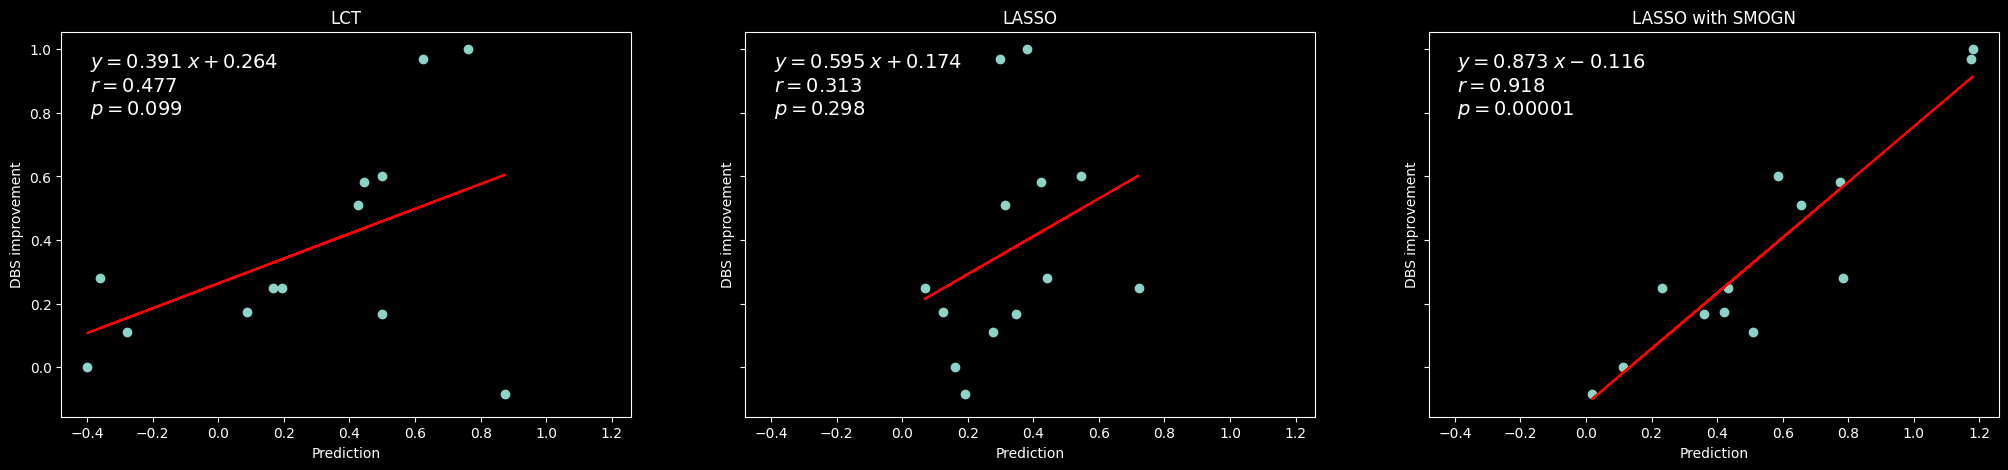

In [17]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,5)
# Cross validation results
[fig,ax] = plt.subplots(1,3,sharex=True, sharey=True)
lr_prepost = linregress(np.asarray(pre_dbs_bdi_improvement_in).astype(float).ravel(),np.asarray(post_dbs_bdi_improvement_in).astype(float).ravel())
ax[0].scatter(pre_dbs_bdi_improvement_in,post_dbs_bdi_improvement_in,)
ax[0].plot(np.asarray(pre_dbs_bdi_improvement_in).ravel(),np.asarray(pre_dbs_bdi_improvement_in).ravel()*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.05, 0.95, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')


lr_pred_ls = linregress(ut_ls,np.asarray(post_dbs_bdi_improvement_in).ravel())
ax[1].scatter(ut_ls,post_dbs_bdi_improvement_in)
ax[1].plot(ut_ls,ut_ls*lr_pred_ls.slope+lr_pred_ls.intercept,'-r')
ax[1].set_title('LASSO')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_ls.slope:0.3f}\;x{lr_pred_ls.intercept:+0.3f}$\n$r = {lr_pred_ls.rvalue:0.3f}$\n$p = {lr_pred_ls.pvalue:0.3f}$"
ax[1].text(0.05, 0.95, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')



lr_pred_qr = linregress(ut_qr,np.asarray(post_dbs_bdi_improvement_in).ravel())
ax[2].scatter(ut_qr,post_dbs_bdi_improvement_in)
ax[2].plot(ut_qr,ut_qr*lr_pred_qr.slope+lr_pred_qr.intercept,'-r')
ax[2].set_title('LASSO with SMOGN')
ax[2].set_ylabel("DBS improvement")
ax[2].set_xlabel("Prediction")
text = f"$y={lr_pred_qr.slope:0.3f}\;x{lr_pred_qr.intercept:+0.3f}$\n$r = {lr_pred_qr.rvalue:0.3f}$\n$p = {Decimal(lr_pred_qr.pvalue):0.1}$"
ax[2].text(0.05, 0.95, text,transform=ax[2].transAxes,
     fontsize=14, verticalalignment='top')


plt.style.use('default')
plt.show

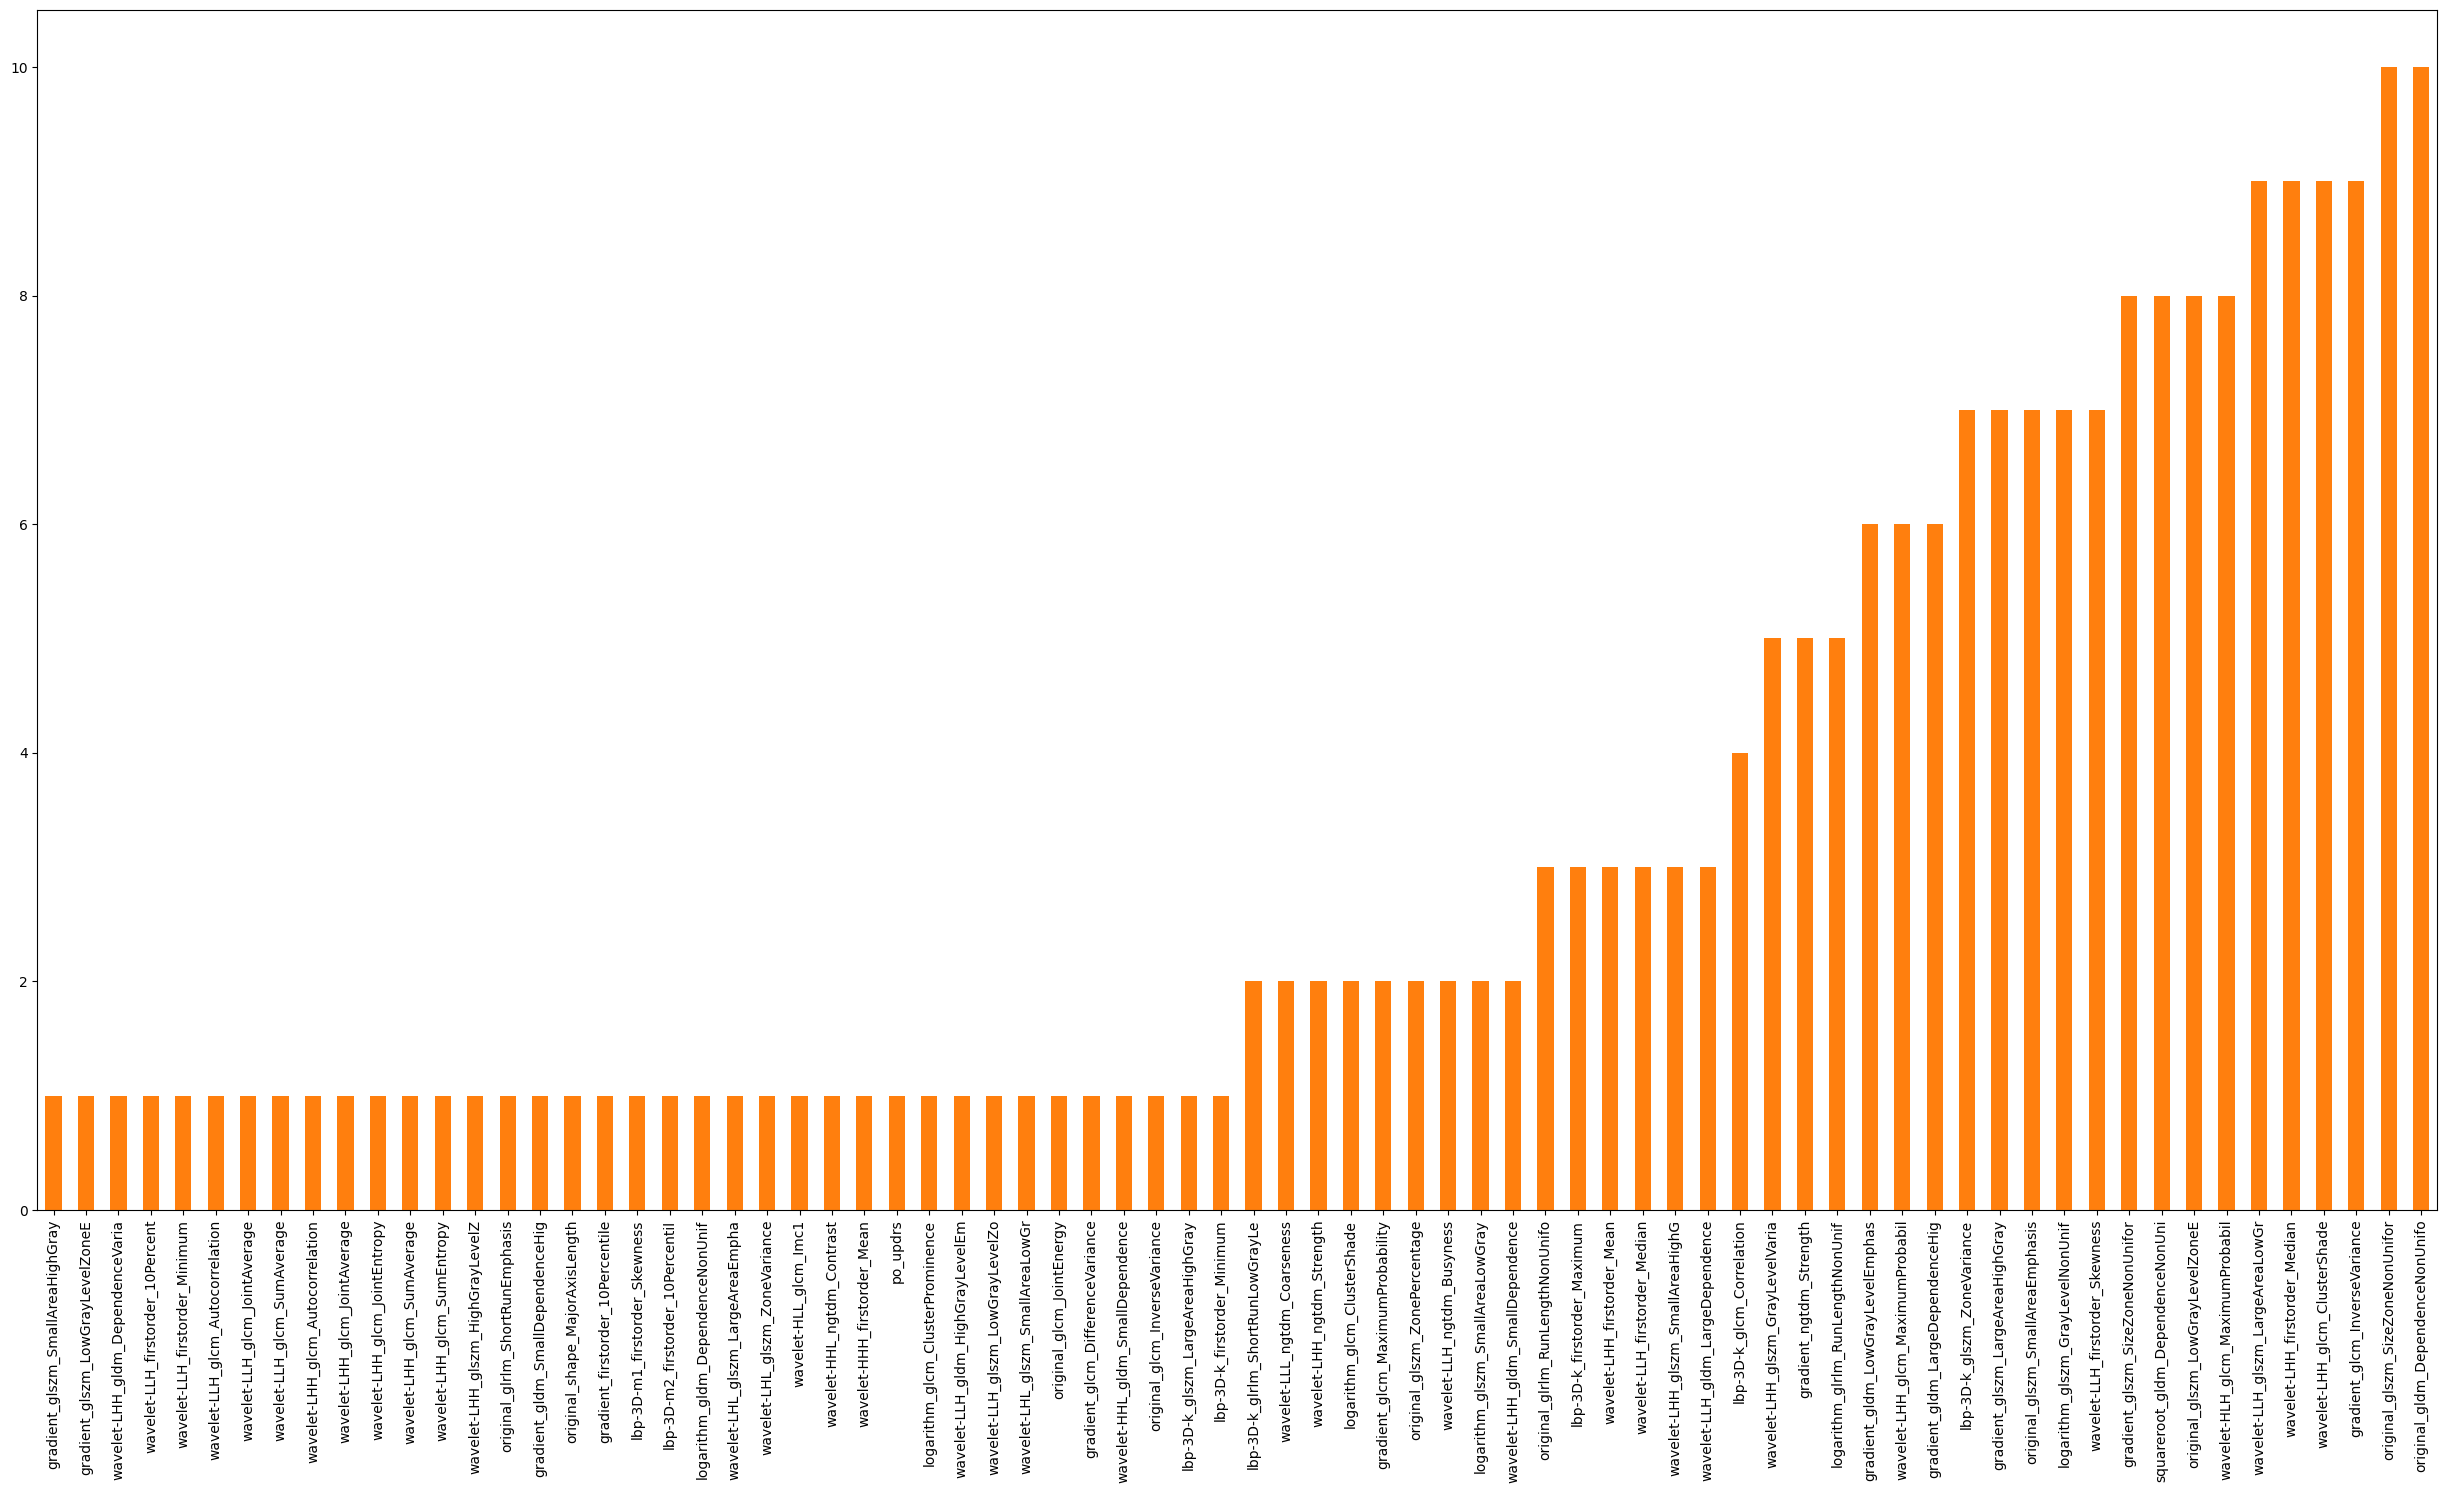

In [18]:
rfs = []
rfss = []
rfsr = []
rfsrs = []
for j in np.arange(Cs.shape[0]-1):
    Kr =  K_all.reshape((n_cases,n_rois,(n_features-1))).transpose((0,2,1))
    #Rr =  R.reshape((n_cases,n_rois,(n_features-1))).transpose((0,2,1))
    Kr_extended = np.zeros((n_cases,n_rois,n_features)).transpose((0,2,1)).astype('str')
    #Rr_extended = np.zeros((n_cases,n_rois,n_features)).transpose((0,2,1)).astype('str')
    Kr_extended[:,0:n_features-1,:] = Kr
    #Rr_extended[:,0:n_features-1,:] = Rr
    Kr_extended[:,-1,:] = 'po_updrs'
    rfs.append(Kr_extended[j,np.asarray(Cs[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])
   # rfsr.append(Rr_extended[j,np.asarray(Ct[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])
    if j < Cs.shape[0]:
        rfss.append(Kr_extended[j,np.asarray(Cs[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])
        #rfsrs.append(Rr_extended[j,np.asarray(Ct[j]!=0).reshape((n_rois,n_features)).transpose((1,0))])

plt.rcParams["figure.figsize"] = (30,15)
fig, axes = plt.subplots(1,1,sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

R = [item for sublist in rfs for item in sublist]
letter_counts = Counter(R)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')


Rs = [item for sublist in rfss for item in sublist]
letter_countss = Counter(Rs)
dfs = pandas.DataFrame.from_dict(letter_countss, orient='index')


uL = list(compress(R, np.in1d(R,Rs)))
colors = np.zeros_like(R)
for j in np.arange(R.__len__()):
    if R[j] in uL:
        colors[j] = "tab:orange"
    else:
        colors[j] = "tab:blue"


df.sort_values(0, inplace=True)
df.plot(ax=axes,y=0, kind='bar', legend=False, color=colors)
# dfs.sort_values(0, inplace=True)
# dfs.plot(ax=axes[1],y=0, kind='bar', legend=False, color=colors)
plt.style.use('dark_background')



In [19]:
# X_so = '/media/mts_dbs/dbs/all/npy/SMOGN/X_smogn_test_bdi_c.npy'
# np.save(X_so,X_smogn)